# EDLDA (Enlarged dimension linear discriminant analysis)

## Difference to LDA
*   by recombination of the original $X_i$'s we expand the search space in hope of finding a transformation where a favorable division is possible\
$X_{LDA}=(X_1, X_2) \rightarrow X_{EDLDA}=(X_1, X_2, X_1X_2, X_1^2, X_2^2)$

## Theory *gerneral discriminant problem*
*   Using Bayes theorem\
$Pr(G=k|X=x)=\frac{f_k(x)\pi_k} {\underset{l=1}{\overset{K}{\sum}}f_l(x)\pi_l}$
    *   $\pi_k$ is the prior probability for class $k$
    *   $f_k(x)$ is a probability density function that $x$ is in class $k$
* we model each class density as multivariate Gaussian\
\
$f_k(x)=\frac{1}{(2\pi)^{p/2}|\Sigma_k|^{1/2}}e^{-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)}$
    *   $\mu_k$ is the mean of observations in class $k$
    *   $p$ is the dimension on the data
    *   $\Sigma_k$ is the covariance matrix of class $k$ 

In [1]:
import math
import random
random.seed(9)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sample_size_Nk = 40

## Generate the sraining set

In [3]:
k1 = pd.DataFrame([random.normalvariate(0,1) for _ in range(sample_size_Nk)], columns=["X1"], dtype=float)
k1['X2'] = [( x1 + random.normalvariate(2,0.7)) for x1 in k1["X1"]]
k1['Class'] = "K1"
k2 = pd.DataFrame([random.normalvariate(-1.5,1) for _ in range(sample_size_Nk)], columns=["X1"], dtype=float)
k2["X2"] = [ -x1 -random.normalvariate(1,1) for x1 in k2["X1"]]
k2['Class'] = "K2"
k3 = pd.DataFrame([random.normalvariate(2,1) for _ in range(sample_size_Nk)], columns=["X1"], dtype=float)
k3["X2"] = [ -x1 -random.normalvariate(2,1) for x1 in k2["X1"]]
k3['Class'] = "K3"
k4 = pd.DataFrame([random.normalvariate(0,1) for _ in range(sample_size_Nk)], columns=["X1"], dtype=float)
k4["X2"] = [ x1 + random.normalvariate(7,0.5) for x1 in k2["X1"]]
k4['Class'] = "K4"
X = pd.concat([k1, k2, k3]) #, k4])

X

,X1,X2,Class
0,-0.101266,2.584062,K1
1,0.242866,2.485527,K1
2,-1.268327,1.287919,K1
3,0.637025,2.064420,K1
4,0.458100,2.254820,K1
...,...,...,...
35,2.376701,-1.771287,K3
36,2.547651,0.783487,K3
37,2.033785,-2.389770,K3
38,2.135584,2.033825,K3


### Expand the original X into 5D

In [4]:
# X1 * X2
X.insert(loc = (len(X.columns)-1), column="X1X2", value=(X["X1"] * X["X2"]))
# X1 ** 2
X.insert(loc = (len(X.columns)-1), column="X1^2", value=(X["X1"] ** 2))
# X2 ** 2
X.insert(loc = (len(X.columns)-1), column="X2^2", value=(X["X2"] ** 2))
display(X)

,X1,X2,X1X2,X1^2,X2^2,Class
0,-0.101266,2.584062,-0.261676,0.010255,6.677374,K1
1,0.242866,2.485527,0.603649,0.058984,6.177846,K1
2,-1.268327,1.287919,-1.633502,1.608653,1.658735,K1
3,0.637025,2.064420,1.315087,0.405801,4.261829,K1
4,0.458100,2.254820,1.032932,0.209855,5.084214,K1
...,...,...,...,...,...,...
35,2.376701,-1.771287,-4.209818,5.648707,3.137456,K3
36,2.547651,0.783487,1.996051,6.490527,0.613852,K3
37,2.033785,-2.389770,-4.860278,4.136282,5.711001,K3
38,2.135584,2.033825,4.343405,4.560718,4.136446,K3


maximum and minimum values and the sample size $N$ is derived from the set

In [5]:
# set the dimensions new
dim_x_max, dim_y_max = X.max(axis=0)[0:2];
dim_x_min, dim_y_min = X.min(axis=0)[0:2];
dim_x_max += 0.5
dim_y_max += 0.5
dim_x_min -= 0.5
dim_y_min -= 0.5
print(f"{dim_x_min:.2f} < X1 < {dim_x_max:.2f}")
print(f"{dim_y_min:.2f} < X2 < {dim_y_max:.2f}")
sample_size_N = len(X.index)
print(f"sample size N = {sample_size_N}")
print(f"class count K = {len(X['Class'].unique()) }")

-4.02 < X1 < 4.29
-3.13 < X2 < 4.15
sample size N = 120
class count K = 3


#### create dict and list for plotting
1.  A dictonary that translates class name to a integer for conturing
2.  A dictonary for the colour of the scatterplot circles
3.  A list such that the colour of the contour filling matches the scatter points colouring

In [6]:
class_dict = {}
color_dict = {}
color_list = []
t = plt.get_cmap("tab10")
for idx, k in enumerate(X['Class'].unique()):
    class_dict[k] = idx
    color_dict[k] = t(idx)
    color_list.append(t(idx))
print(class_dict)
print(color_dict)
print(color_list)

{'K1': 0, 'K2': 1, 'K3': 2}
{'K1': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'K2': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'K3': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)}
[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)]


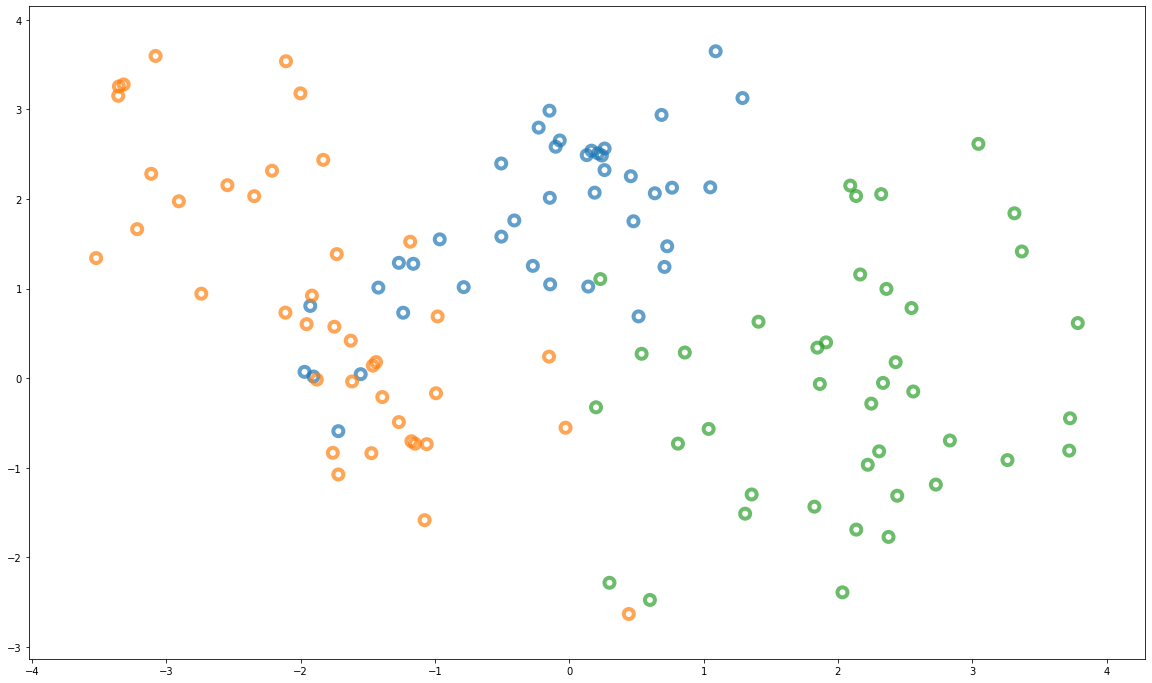

In [7]:
plt.figure(figsize=(20,12))
for c, rows in X.groupby('Class'):
    plt.scatter(rows["X1"], rows["X2"], facecolor='None', edgecolors=color_dict[c], alpha=0.7, s=100, linewidths=4)

plt.ylim([dim_y_min,dim_y_max])
plt.xlim([dim_x_min,dim_x_max])
plt.show()

## Estimate Paramters using training data

#### Prior probablity
*   prior probability of being class k\
\
$\hat\pi_k=\frac{N_k}{N}$
    +   $N$ is the total number of observations

    +   $N_k$ is the number of class-$k$ observations
#### Class mean 
*   the mean in a class $k$\
\
$\hat\mu_k=\underset{g_i = k}\sum\frac{x_i}{N_k}$
#### Common covariance matrix $\Sigma$
*   by assumtion all classes have the same covariance matrix\
\
$\Sigma_k = \Sigma\text{ }\forall k$\
\
$\hat\Sigma = \underset{k=1}{\overset{K}{\sum}}\bigg\lgroup\underset{g_i=k}{\sum}(x_i-\hat\mu_k)(x_i-\hat\mu_k)^T\bigg\rgroup / (N-K)$
    +   basically the normal way to calculate the covariance matrix except that depending on the class of the observation the class-specific mean is substracted
    +   at the end its adhusted by the number of observations $N$ corrected for the number of classes $K$ 
        +   I think this has to do with degrees of freedom but not sure

In [8]:
sigmahat = np.zeros((len(X.columns)-1,len(X.columns)-1) )
muhat = pd.DataFrame(columns=X['Class'].unique())
pi = pd.DataFrame( np.zeros((len(X['Class'].unique()),1)),columns=["count"], index=X['Class'].unique())
# iter over the classes
for c, rows in X.groupby('Class'):
    rows = rows.drop(columns="Class").T
    muhat[c] = rows.mean(axis=1)
    pi["count"][c] = rows.shape[1]
    sigmahat = sigmahat + rows.sub(rows.mean(axis=1), axis=0) @ rows.sub(rows.mean(axis=1), axis=0).T
sigmahat = pd.DataFrame(sigmahat / (sample_size_N -len(X['Class'].unique())))
# calc the proportion for pi
pi["proportion"] = pi["count"] / pi["count"].sum()
print("porportion pi")
display(pi)
print("means")
display(muhat)
print("sigma")
sigmahat

porportion pi


,count,proportion
K1,40.0,0.333333
K2,40.0,0.333333
K3,40.0,0.333333


means


,K1,K2,K3
X1,-0.210509,-1.852380,2.065111
X2,1.744025,0.849102,-0.131957
X1X2,0.237885,-2.636760,0.030242
X1^2,0.825567,4.284585,5.178770
X2^2,3.941813,3.068947,1.691440


sigma


,X1,X2,X1X2,X1^2,X2^2
X1,0.871322,-0.053379,1.326405,-0.063386,-0.023821
X2,-0.053379,1.682800,-0.431903,1.498087,2.455980
X1X2,1.326405,-0.431903,8.230882,-3.171009,-3.118479
X1^2,-0.063386,1.498087,-3.171009,9.808043,2.024739
X2^2,-0.023821,2.455980,-3.118479,2.024739,9.759176


## Using the linear discriminant functions

+   use the parameters estimated above

### ***Linear** discriminant function*
*   returns how likely the observation $x$ belongs to class $k$\
\
$\delta_k(x)=x^T\Sigma^{-1}\hat\mu_k-\frac{1}{2}\hat\mu_k^T\Sigma^{-1}\hat\mu_k+\log(\pi_k)$

### Classification using $\delta_k(x$)
*   using the *linear discriminant function* to decided which class fits best\
\
$G(x)= \underset{k}\argmax\text{ }\delta_k(x)$
 


In [9]:
delta_kx = lambda x, k: x.T @ np.linalg.inv(sigmahat) @ muhat[k] - 1/2 *(muhat[k].T @ np.linalg.inv(sigmahat) @ muhat[k]) + math.log(pi["proportion"][k])

def argmax_k(x):
    deltas = []
    for c in X['Class'].unique():
        deltas.append((delta_kx(x, c), c))
    _, c = max(deltas)
    return class_dict[c]

### Evaluate the classificator in a grid for plotting

In [12]:
xx = np.linspace(dim_x_min, dim_x_max, 300)
yy = np.linspace(dim_y_min, dim_y_max, 300)
list = []
for yi in yy:
    col = []
    for xi in xx:
        # print(xi, yi)
        col.append(argmax_k(np.array([xi,yi, xi*yi, xi**2, yi**2])))
    list.append(col)
zz = np.array(list)
# print(zz)

### Plot
1.  Plot the conture of $G(x)$
2.  Plot the training data

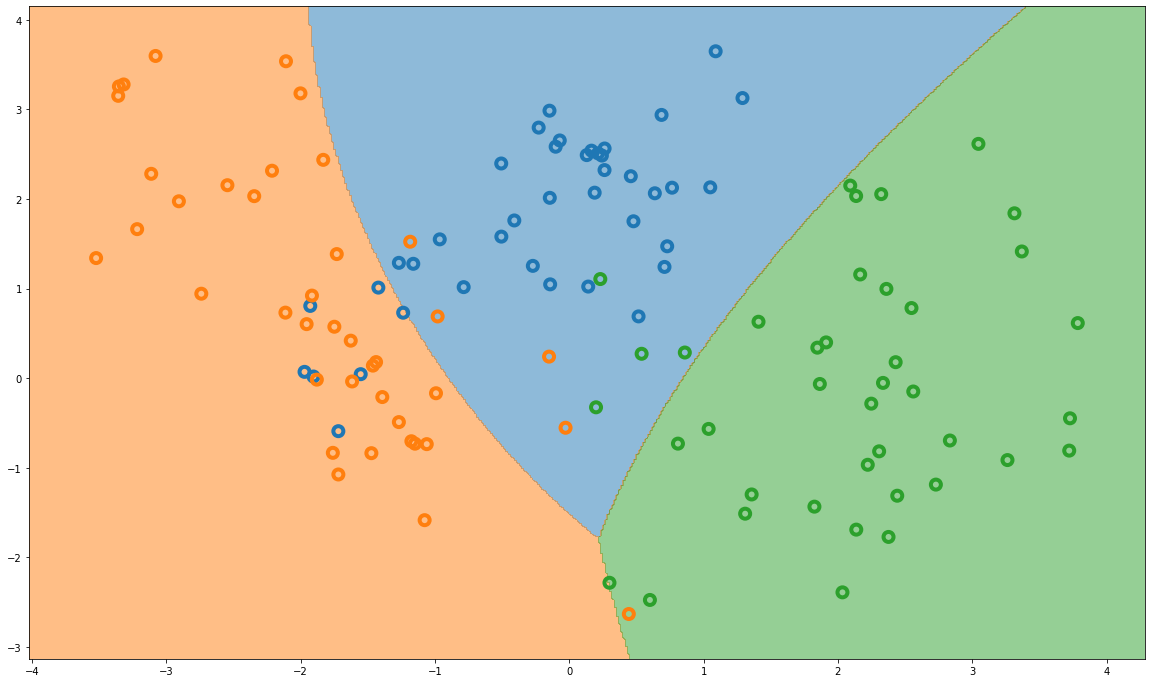

In [13]:

plt.figure(figsize=(20,12))
# plt.rcParams["figure.dpi"] = (1000)
h = plt.contourf(xx, yy, zz, levels=(len(class_dict)-1), alpha = 0.5, colors=color_list)
for c, rows in X.groupby('Class'):
    plt.scatter(rows["X1"], rows["X2"], facecolor='None', edgecolors=color_dict[c], alpha=1, s=100, linewidths=4)
plt.ylim([dim_y_min,dim_y_max])
plt.xlim([dim_x_min,dim_x_max])
plt.show()